# Analysis of Foursquare Data

# NYU - CUSP UDP Capstone
# Foursquare + NYC Merge by CT 
## Brief
This notebook 
1. Part I. Data Processing

    - import Foursquare data
    - imports the Census Tract shapefile
    - import Typologies
    - merges topologies
    - Spatail join by Census Tract
    - merges topologies
    - map topologies
    - map Businesses
1. Part II. Modeling
    - Performs a classifcation task on Typologies
###  You can refer to https://github.com/mv1742/updny_2

# Part I. Data Processing


In [ ]:
import os
import requests
import shapely
import json

# !conda install graphviz

# !pip install pydot

# !pip install pydotplus
from sklearn import tree
from IPython.display import Image  
import pydotplus

import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline
#import statsmodels.formula.api as smf
import itertools
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.metrics import silhouette_score
# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
import pandas as pd
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster
# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
import pandas as pd
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from geopandas import GeoDataFrame
from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


%pylab inline

# Foursquare Data
- import Foursquare data

In [20]:
data = gpd.read_file('NYU_March2018_subset30.geojson')

In [21]:
(list(data.columns)), data.shape

([u'id',
  u'Place Name',
  u'Rating',
  u'Checkins',
  u'Users',
  u'Visits',
  u'Pricing',
  u'Type',
  u'Category',
  u'Class',
  'geometry'],
 (106287, 11))

In [22]:
data.head(1)

,id,Place Name,Rating,Checkins,Users,Visits,Pricing,Type,Category,Class,geometry
0,50ad0afce4b0b4a7430e2268,Terry's Wine Shop,8.8,294,217,337,NaN,Wine Shop,Consumption,Optional,POINT (-74.00034036700906 40.73518392010902)


In [23]:
list(data.columns)[-4:-1]

[u'Type', u'Category', u'Class']

In [24]:
X_dummies = data[list(data.columns)[-4:-1]]
print(X_dummies.shape)
X_dummies = pd.get_dummies(X_dummies)
Fq_dummies = pd.concat([data, X_dummies], axis=1, join='inner')  
Fq_dummies.shape

(106287, 3)


(106287, 716)

# Census Tract shapefile
- imports the Census Tract shapefile


In [25]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/Capstone/udpny_2".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))

Master: /nfshome/mv1742/Capstone/udpny_2


In [26]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/Capstone/udpny_2".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))
def getGeoDataFrameFromShpFileZipUrl(url):
    '''
    This function downloads the zip file, unzips it into the dorectory 
    pointed to by PUIdata environment variable. Then it 
    reads it into a gepandas dataframe
    '''
    
    folderName = 'shape'+ \
        str(len(os.listdir(os.getenv('TaxiData')))+1)
    os.makedirs(os.getenv('Master') + '/' + folderName)
    urlretrieve(url, "region.zip")
    os.system('unzip -d $Master'+'/'+folderName+' region.zip')
    filenames = [f for f in os.listdir(os.getenv('Master') + '/' + folderName) if f.endswith('.shp') ]
    shapeFile = filenames[0]
    shapeFilePath = os.getenv('Master') + '/' + folderName + '/' + shapeFile
    return gpd.GeoDataFrame.from_file(shapeFilePath)


Master: /nfshome/mv1742/Capstone/udpny_2


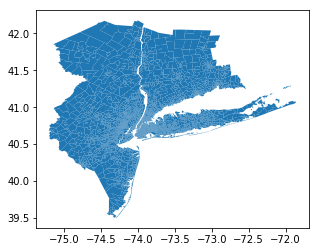

In [27]:
# url = 'https://planninglabs.carto.com/api/v2/sql?filename=region&q=SELECT%20%2A%20FROM%20region_censustract_v0&format=SHP'
# NYCzip = getGeoDataFrameFromShpFileZipUrl(url)
NYCzip=gpd.read_file('Censustracts/region.shp')
NYCzip.plot()

In [28]:
NYCzip.columns

Index([  u'aland_mi',   u'objectid',    u'statefp',   u'countyfp',
          u'tractce',      u'geoid',       u'name',   u'namelsad',
            u'mtfcc',   u'funcstat',      u'aland',     u'awater',
         u'intptlat',   u'intptlon', u'shape_leng', u'shape_area',
           u'atotal',  u'atotal_mi', u'cartodb_id',    u'geoid_1',
            u'hou16',   u'hou16moe',    u'hou16cv',     u'houv16',
        u'houv16moe',   u'houv16cv',     u'houo16',  u'houo16moe',
         u'houo16cv',     u'hour16',  u'hour16moe',   u'hour16cv',
          u'emtot15',     u'empr15',    u'emoff15',    u'emins15',
          u'emind15',    u'emser15',    u'emoth15',   u'geometry'],
      dtype='object')

In [29]:
NYCzip.rename(columns={"geoid": "GEOID"},inplace=True)
NYCzip.GEOID = NYCzip.GEOID.astype(int)
cols = ['GEOID','geometry']
NYCzip = NYCzip.loc[:,cols]
#NYCzipgdp.plot(column='GEOID',legend = True)
NYCzip.shape
NYCzip.isnull().sum()

GEOID       0
geometry    0
dtype: int64

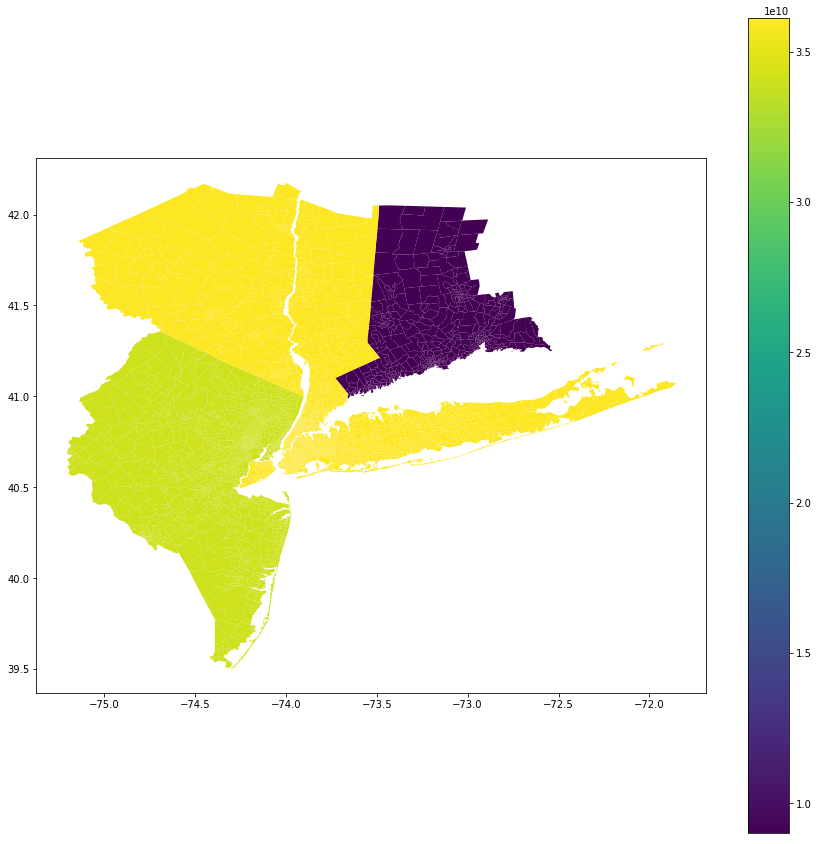

In [30]:
figure, ax = plt.subplots(figsize=(15, 15))
NYCzip.plot(column='GEOID',legend = True, ax=ax)

# Typologies
- import Typologies
- merges topologies
- map topologies

In [31]:
Typologiespd=pd.read_csv('NY_final_data_for_typologies_1.19.19.csv')
Typologiesgdp = gpd.GeoDataFrame(Typologiespd)
len(Typologiesgdp.columns)

82

In [32]:
Typologiesgdp['Type_1.19'].replace('MHI - Advanced Exclusion','MHI - Ongoing Exclusion',inplace=True)
Typologiesgdp['Type_1.19'].unique()



array(['VHI - Super Gentrification or Exclusion',
       'MHI - Ongoing Exclusion',
       'MHI - Stable or Early Stage of Exclusion',
       'MHI - Advanced Exclusion', 'LI - At Risk of Gentrification',
       'MHI - Advanced Gentrification',
       'LI - Not Losing Low-Income Households',
       'LI - Ongoing Displacement of Low-Income Households',
       'Missing Data', 'LI - Ongoing Gentrification', nan], dtype=object)

In [33]:
# Typologiesgdp['Type_binary'] = Typologiesgdp['Type_1.19']
# Typologiesgdp['Type_binary'].replace('VHI - Super Gentrification or Exclusion',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Ongoing Exclusion',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Stable or Early Stage of Exclusion',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Advanced Exclusion', 0,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Advanced Gentrification',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - At Risk of Gentrification',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - Ongoing Gentrification',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - Not Losing Low-Income Households',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - Ongoing Displacement of Low-Income Households',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('Missing Data',0,inplace=True)
# Typologiesgdp['Type_binary'].replace(nan,0,inplace=True)


In [34]:
# Typologiesgdp['Type_binary'].unique()

In [35]:
# Typologiesgdp.to_csv('typologies_binary.csv')
# Typologiesgdp.drop(columns='Type_binary', inplace=True)

In [36]:
Typologiesgdp.rename(columns={'geoid': "GEOID"},inplace=True)
Typologiesgdp.tail()
cols_typ = ['GEOID','pop16','hinc16','Type_1.19']
print(type(Typologiesgdp.iloc[:,0][0]))
#Typologies.rename(columns={'\ufeffgeoid': "GEOID"},inplace=True)
#Typologiesgdp.geoid = Typologies.iloc[:,0]
Typologiesgdp = Typologiesgdp.loc[:,cols_typ]
Typologiesgdp.head()

<type 'numpy.float64'>


,GEOID,pop16,hinc16,Type_1.19
0,9.001010e+09,4132.0,150655.0,VHI - Super Gentrification or Exclusion
1,9.001010e+09,4174.0,250000.0,VHI - Super Gentrification or Exclusion
2,9.001010e+09,3277.0,212448.0,VHI - Super Gentrification or Exclusion
3,9.001010e+09,5546.0,187875.0,VHI - Super Gentrification or Exclusion
4,9.001010e+09,4049.0,221250.0,VHI - Super Gentrification or Exclusion


In [37]:
merged = NYCzip.merge(Typologiesgdp,on='GEOID')
merged.tail()

,GEOID,geometry,pop16,hinc16,Type_1.19
5285,36061021703,POLYGON ((-73.94607800039937 40.82126399983373...,8.0,NaN,Missing Data
5286,36061021800,POLYGON ((-73.94872800029694 40.80333100022552...,7110.0,48429.0,LI - Ongoing Gentrification
5287,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",6415.0,21585.0,LI - Ongoing Displacement of Low-Income Househ...
5288,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,2451.0,41635.0,LI - Ongoing Gentrification
5289,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",3496.0,85147.0,MHI - Stable or Early Stage of Exclusion


In [38]:
print(type(merged),merged.shape)
mergedgpd = gpd.GeoDataFrame(merged)
mergedgpd.shape

(<class 'geopandas.geodataframe.GeoDataFrame'>, (5290, 5))


(5290, 5)

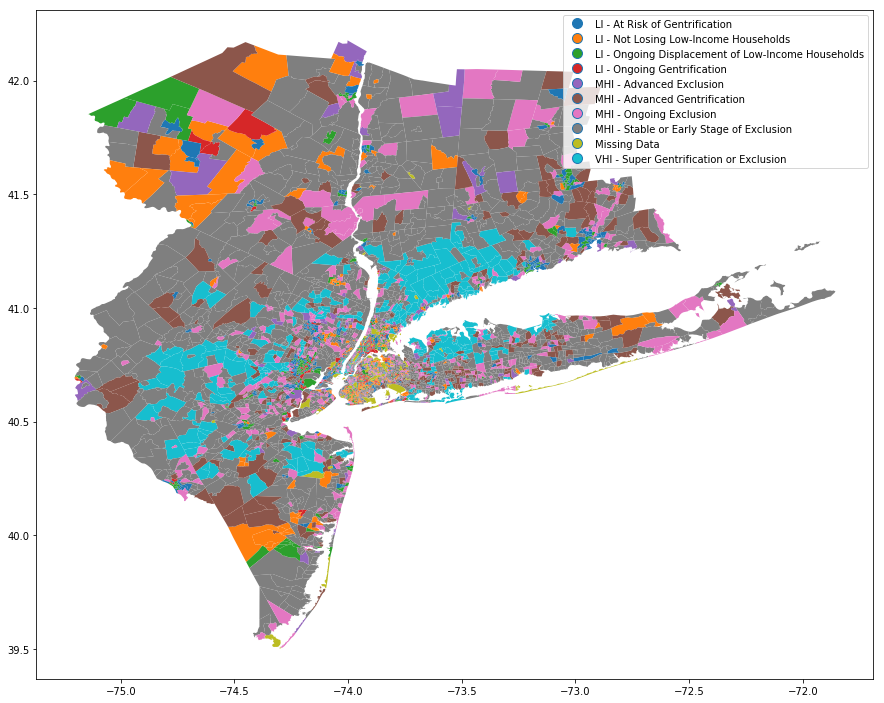

In [39]:
figure, ax = plt.subplots(figsize=(15, 15))
mergedgpd.plot(column='Type_1.19',legend = True, ax=ax)

# Spatail Join
- Spatail join by Census Tract
- map Businesses


In [40]:
mergedgpd.crs, data.crs, mergedgpd.shape, data.shape

(None, {u'init': u'epsg:4326'}, (5290, 5), (106287, 11))

In [41]:
mergedgpd.crs = {'init' :'epsg:4326'}

In [42]:
mergedgpd.crs

{'init': 'epsg:4326'}

In [43]:
data_sjoined = gpd.sjoin(mergedgpd,Fq_dummies, op="contains")

In [44]:
data_sjoined.drop(columns = ['geometry','pop16','hinc16', 'index_right','Type_1.19'], inplace=True)

In [45]:
# list(data_sjoined.columns)

In [46]:
data_sjoined_sum = data_sjoined.groupby(by='GEOID').sum()
print(data_sjoined_sum.shape,data_sjoined_sum.columns)
data_sjoined_sum_merged = data_sjoined_sum.merge(mergedgpd.loc[:,['GEOID','pop16','hinc16','Type_1.19', 'geometry']],on='GEOID')
print(data_sjoined_sum_merged.shape,data_sjoined_sum_merged.columns)
data_sjoined_sum_merged = gpd.GeoDataFrame(data_sjoined_sum_merged)
print(data_sjoined_sum_merged.shape,data_sjoined_sum_merged.columns)

((3009, 710), Index([u'Rating', u'Checkins', u'Users', u'Visits', u'Pricing', u'Type_ATM',
       u'Type_Accessories Store', u'Type_Acupuncturist',
       u'Type_Adult Boutique', u'Type_Adult Education Center',
       ...
       u'Category_Leisure', u'Category_Mobility', u'Category_Nutrition',
       u'Category_Personal care', u'Category_Social', u'Category_Taking care',
       u'Category_Unknown', u'Class_', u'Class_Necessary', u'Class_Optional'],
      dtype='object', length=710))
((3009, 715), Index([                 u'GEOID',                 u'Rating',
                     u'Checkins',                  u'Users',
                       u'Visits',                u'Pricing',
                     u'Type_ATM', u'Type_Accessories Store',
           u'Type_Acupuncturist',    u'Type_Adult Boutique',
       ...
              u'Category_Social',   u'Category_Taking care',
             u'Category_Unknown',                 u'Class_',
              u'Class_Necessary',         u'Class_Optional',

In [47]:
Fq_dummies.shape,data_sjoined_sum.shape, len(data_sjoined_sum_merged.GEOID.unique())

((106287, 716), (3009, 710), 3009)

In [48]:
data_sjoined_sum_merged.rename(columns={"Type_1.19": "Typologies"}, inplace = True)

In [49]:
# plt.rcParams['figure.figsize'] = (30, 20)
# ax = data_sjoined_sum_merged.plot(column='Checkins', scheme='quantiles', cmap='OrRd')
# ax.legend()

In [50]:
# data_sjoined_sum_merged.drop(columns= 'index_right',inplace=True)
data_sjoined_sum_merged.iloc[:,:6]
data_sjoined_sum_merged.columns

Index([                 u'GEOID',                 u'Rating',
                     u'Checkins',                  u'Users',
                       u'Visits',                u'Pricing',
                     u'Type_ATM', u'Type_Accessories Store',
           u'Type_Acupuncturist',    u'Type_Adult Boutique',
       ...
              u'Category_Social',   u'Category_Taking care',
             u'Category_Unknown',                 u'Class_',
              u'Class_Necessary',         u'Class_Optional',
                        u'pop16',                 u'hinc16',
                   u'Typologies',               u'geometry'],
      dtype='object', length=715)

In [51]:
# sfig = pd.scatter_matrix(data_sjoined_sum_merged.iloc[:,1:5], s=30, figsize=(10, 10), diagonal='kde')

In [52]:
data_sjoined_sum_merged.columns

Index([                 u'GEOID',                 u'Rating',
                     u'Checkins',                  u'Users',
                       u'Visits',                u'Pricing',
                     u'Type_ATM', u'Type_Accessories Store',
           u'Type_Acupuncturist',    u'Type_Adult Boutique',
       ...
              u'Category_Social',   u'Category_Taking care',
             u'Category_Unknown',                 u'Class_',
              u'Class_Necessary',         u'Class_Optional',
                        u'pop16',                 u'hinc16',
                   u'Typologies',               u'geometry'],
      dtype='object', length=715)

In [53]:
# data_sjoined_sum_merged['Class_Optional']/ 

# Increase features!!!!

In [54]:
# X_foursquare = data_sjoined_sum_merged.drop(['Typologies','geometry'],axis =1).copy()

X_foursquare = data_sjoined_sum_merged.drop(['Typologies','geometry'],axis =1).copy()
# X_foursquare['pop16'].replace(0,mean(X_foursquare['pop16']), inplace=True)
# for column in X_foursquare.columns:
#     print(column)
#     X_foursquare[column+' per person'] = X_foursquare[column]/X_foursquare['pop16']

In [55]:
X_foursquare.hinc16[X_foursquare['hinc16']==0]
X_foursquare['hinc16'].replace(nan,mean(X_foursquare['hinc16']),inplace=True)
X_foursquare['hinc16'].replace(0,mean(X_foursquare['hinc16']),inplace=True)

In [56]:
n_clusters = 5
km = KMeans(random_state=234,n_clusters=n_clusters)
res=km.fit(np.asarray(X_foursquare.hinc16).reshape(len(X_foursquare.hinc16),1))
y_clusters = res.labels_
y_clusters.shape

(3009,)

In [57]:
X_foursquare['clusters']=y_clusters

In [58]:
pdmaps = {}
for cluster in X_foursquare['clusters'].unique():
    print(cluster)
    pdmaps[cluster] = pd.DataFrame(X_foursquare[y_clusters == cluster])


2
0
3
1
4


In [59]:
pdmaps[2].Class_Necessary.sum()

9343.0

In [60]:
total_type = {}
for cluster in X_foursquare['clusters'].unique():
    print(cluster)
    total_type[cluster] = {}
    for fq in list(pdmaps[cluster].columns[5:-2]):
        total_type[cluster][fq] = pdmaps[cluster][fq].sum()

2
0
3
1
4


In [61]:
total_type[2]['Class_Necessary']

9343.0

In [62]:
len(X_foursquare[X_foursquare.clusters == 0])

233

In [63]:
# X_foursquare[X_foursquare.clusters == 0]

In [64]:
total_type[0]['Class_Necessary']

4803.0

In [80]:
X_foursquare['Class_Necessary_per_income_strata_'+str(0)] =  X_foursquare[X_foursquare.clusters == 0]['Class_Necessary']/total_type[0]['Class_Necessary']
X_foursquare['Class_Necessary_per_income_strata_'+str(0)].replace(nan,0, inplace=True)
X_foursquare['Class_Necessary_per_income_strata_'+str(0)] 

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
6       0.000000
7       0.000000
8       0.000000
9       0.000000
10      0.000000
11      0.000000
12      0.000000
13      0.000000
14      0.000000
15      0.000000
16      0.000000
17      0.004789
18      0.000000
19      0.001457
20      0.000000
21      0.000000
22      0.000000
23      0.002082
24      0.013117
25      0.000000
26      0.000000
27      0.000000
28      0.000000
29      0.000000
          ...   
2979    0.000000
2980    0.000000
2981    0.000000
2982    0.000000
2983    0.000000
2984    0.000000
2985    0.000000
2986    0.000000
2987    0.000000
2988    0.000000
2989    0.000000
2990    0.000000
2991    0.000000
2992    0.000000
2993    0.001457
2994    0.000000
2995    0.002290
2996    0.000000
2997    0.000000
2998    0.000000
2999    0.000000
3000    0.000000
3001    0.000000
3002    0.000000
3003    0.000000
3004    0.000000
3005    0.000000
3006    0.0000

In [71]:
# X_foursquare['Class_necessary_per_income_strata_'+str(0)]
len(pdmaps[cluster].columns[5:-3])

706

In [82]:
# X_foursquare.pop16
pdmaps[cluster].columns[6:-3]
X_foursquare['clusters'].unique()

array([2, 0, 3, 1, 4])

In [81]:
for cluster in X_foursquare['clusters'].unique():
    for fq in list(pdmaps[cluster].columns[6:-3]):
        print(fq)
        print(cluster)
        X_foursquare[fq+'_per_income_strata_'+str(cluster)] = X_foursquare[X_foursquare.clusters == cluster][fq]/total_type[cluster][fq]
        X_foursquare[fq+'_per_income_strata_'+str(cluster)].replace(nan,0, inplace=True)

Type_ATM
2
Type_Accessories Store
2
Type_Acupuncturist
2
Type_Adult Boutique
2
Type_Adult Education Center
2
Type_Advertising Agency
2
Type_Afghan Restaurant
2
Type_African Restaurant
2
Type_Airport
2
Type_Airport Food Court
2
Type_Airport Gate
2
Type_Airport Lounge
2
Type_Airport Service
2
Type_Airport Terminal
2
Type_Airport Tram
2
Type_Alternative Healer
2
Type_American Restaurant
2
Type_Amphitheater
2
Type_Animal Shelter
2
Type_Antique Shop
2
Type_Apres Ski Bar
2
Type_Aquarium
2
Type_Arcade
2
Type_Arepa Restaurant
2
Type_Argentinian Restaurant
2
Type_Art Gallery
2
Type_Art Museum
2
Type_Art Studio
2
Type_Arts & Crafts Store
2
Type_Arts & Entertainment
2
Type_Asian Restaurant
2
Type_Assisted Living
2
Type_Astrologer
2
Type_Athletics & Sports
2
Type_Auditorium
2
Type_Australian Restaurant
2
Type_Austrian Restaurant
2
Type_Auto Dealership
2
Type_Auto Garage
2
Type_Auto Workshop
2
Type_Automotive Shop
2
Type_BBQ Joint
2
Type_Baby Store
2
Type_Badminton Court
2
Type_Bagel Shop
2
Type_Ba

Type_Lighthouse
2
Type_Lighting Store
2
Type_Lingerie Store
2
Type_Liquor Store
2
Type_Locksmith
2
Type_Lounge
2
Type_Luggage Store
2
Type_Mac & Cheese Joint
2
Type_Malay Restaurant
2
Type_Marijuana Dispensary
2
Type_Market
2
Type_Martial Arts Dojo
2
Type_Massage Studio
2
Type_Maternity Clinic
2
Type_Mattress Store
2
Type_Medical Center
2
Type_Medical Lab
2
Type_Medical School
2
Type_Medical Supply Store
2
Type_Mediterranean Restaurant
2
Type_Meeting Room
2
Type_Memorial Site
2
Type_Men's Store
2
Type_Mental Health Office
2
Type_Metro Station
2
Type_Mexican Restaurant
2
Type_Middle Eastern Restaurant
2
Type_Middle School
2
Type_Military Base
2
Type_Mini Golf
2
Type_Miscellaneous Shop
2
Type_Mobile Phone Shop
2
Type_Modern European Restaurant
2
Type_Modern Greek Restaurant
2
Type_Molecular Gastronomy Restaurant
2
Type_Monastery
2
Type_Monument / Landmark
2
Type_Moroccan Restaurant
2
Type_Mosque
2
Type_Motel
2
Type_Motorcycle Shop
2
Type_Motorsports Shop
2
Type_Mountain
2
Type_Movie Thea

Type_Bridge
0
Type_Bubble Tea Shop
0
Type_Buddhist Temple
0
Type_Buffet
0
Type_Building
0
Type_Burger Joint
0
Type_Burmese Restaurant
0
Type_Burrito Place
0
Type_Bus Line
0
Type_Bus Station
0
Type_Bus Stop
0
Type_Business Center
0
Type_Business Service
0
Type_Butcher
0
Type_Cable Car
0
Type_Cafeteria
0
Type_Café
0
Type_Cajun / Creole Restaurant
0
Type_Cambodian Restaurant
0
Type_Camera Store
0
Type_Campaign Office
0
Type_Campground
0
Type_Candy Store
0
Type_Cantonese Restaurant
0
Type_Capitol Building
0
Type_Car Wash
0
Type_Caribbean Restaurant
0
Type_Carpet Store
0
Type_Casino
0
Type_Castle
0
Type_Caucasian Restaurant
0
Type_Cave
0
Type_Cemetery
0
Type_Cha Chaan Teng
0
Type_Chaat Place
0
Type_Check Cashing Service
0
Type_Cheese Shop
0
Type_Child Care Service
0
Type_Chinese Restaurant
0
Type_Chiropractor
0
Type_Chocolate Shop
0
Type_Christmas Market
0
Type_Church
0
Type_Churrascaria
0
Type_Circus
0
Type_Circus School
0
Type_City
0
Type_City Hall
0
Type_Climbing Gym
0
Type_Clothing Stor

Type_Pawn Shop
0
Type_Pedestrian Plaza
0
Type_Performing Arts Venue
0
Type_Perfume Shop
0
Type_Persian Restaurant
0
Type_Peruvian Restaurant
0
Type_Pet Café
0
Type_Pet Service
0
Type_Pet Store
0
Type_Pharmacy
0
Type_Photography Lab
0
Type_Photography Studio
0
Type_Physical Therapist
0
Type_Piano Bar
0
Type_Pie Shop
0
Type_Pier
0
Type_Piercing Parlor
0
Type_Pilates Studio
0
Type_Pizza Place
0
Type_Plane
0
Type_Planetarium
0
Type_Platform
0
Type_Playground
0
Type_Plaza
0
Type_Police Station
0
Type_Polish Restaurant
0
Type_Pool
0
Type_Pool Hall
0
Type_Pop-Up Shop
0
Type_Port
0
Type_Portuguese Restaurant
0
Type_Post Office
0
Type_Power Plant
0
Type_Prayer Room
0
Type_Preschool
0
Type_Print Shop
0
Type_Prison
0
Type_Private School
0
Type_Professional & Other Places
0
Type_Pub
0
Type_Public Art
0
Type_Public Bathroom
0
Type_RV Park
0
Type_Racetrack
0
Type_Radio Station
0
Type_Rafting
0
Type_Ramen Restaurant
0
Type_Real Estate Office
0
Type_Record Shop
0
Type_Recording Studio
0
Type_Recreatio

Type_College Math Building
3
Type_College Quad
3
Type_College Rec Center
3
Type_College Residence Hall
3
Type_College Science Building
3
Type_College Soccer Field
3
Type_College Stadium
3
Type_College Technology Building
3
Type_College Tennis Court
3
Type_College Theater
3
Type_College Track
3
Type_Colombian Restaurant
3
Type_Comedy Club
3
Type_Comfort Food Restaurant
3
Type_Comic Shop
3
Type_Community Center
3
Type_Community College
3
Type_Concert Hall
3
Type_Conference
3
Type_Conference Room
3
Type_Confucian Temple
3
Type_Construction & Landscaping
3
Type_Convenience Store
3
Type_Convention
3
Type_Convention Center
3
Type_Cooking School
3
Type_Corporate Amenity
3
Type_Corporate Cafeteria
3
Type_Corporate Coffee Shop
3
Type_Cosmetics Shop
3
Type_Costume Shop
3
Type_Country Dance Club
3
Type_County
3
Type_Courthouse
3
Type_Coworking Space
3
Type_Credit Union
3
Type_Creperie
3
Type_Cricket Ground
3
Type_Cruise
3
Type_Cuban Restaurant
3
Type_Cultural Center
3
Type_Cupcake Shop
3
Type_Cur

Type_Romanian Restaurant
3
Type_Roof Deck
3
Type_Rugby Pitch
3
Type_Russian Restaurant
3
Type_Sake Bar
3
Type_Salad Place
3
Type_Salon / Barbershop
3
Type_Salsa Club
3
Type_Salvadoran Restaurant
3
Type_Sandwich Place
3
Type_Sauna / Steam Room
3
Type_Sausage Shop
3
Type_Scandinavian Restaurant
3
Type_Scenic Lookout
3
Type_School
3
Type_Science Museum
3
Type_Sculpture Garden
3
Type_Seafood Restaurant
3
Type_Shabu-Shabu Restaurant
3
Type_Shanghai Restaurant
3
Type_Shipping Store
3
Type_Shoe Repair
3
Type_Shoe Store
3
Type_Shop & Service
3
Type_Shopping Mall
3
Type_Shopping Plaza
3
Type_Shrine
3
Type_Skate Park
3
Type_Skating Rink
3
Type_Ski Area
3
Type_Ski Chalet
3
Type_Ski Lodge
3
Type_Ski Trail
3
Type_Smoke Shop
3
Type_Smoothie Shop
3
Type_Snack Place
3
Type_Soccer Field
3
Type_Soccer Stadium
3
Type_Social Club
3
Type_Sorority House
3
Type_Soup Place
3
Type_South American Restaurant
3
Type_South Indian Restaurant
3
Type_Southern / Soul Food Restaurant
3
Type_Souvenir Shop
3
Type_Souvlak

Type_Distillery
1
Type_Distribution Center
1
Type_Dive Bar
1
Type_Dive Spot
1
Type_Doctor's Office
1
Type_Dog Run
1
Type_Doner Restaurant
1
Type_Donut Shop
1
Type_Dosa Place
1
Type_Driving School
1
Type_Drugstore
1
Type_Dry Cleaner
1
Type_Dumpling Restaurant
1
Type_Duty-free Shop
1
Type_EV Charging Station
1
Type_Eastern European Restaurant
1
Type_Electronics Store
1
Type_Elementary School
1
Type_Embassy / Consulate
1
Type_Emergency Room
1
Type_Empanada Restaurant
1
Type_Entertainment Service
1
Type_Erotic Museum
1
Type_Ethiopian Restaurant
1
Type_Event Service
1
Type_Event Space
1
Type_Exhibit
1
Type_Eye Doctor
1
Type_Fabric Shop
1
Type_Factory
1
Type_Fair
1
Type_Falafel Restaurant
1
Type_Farm
1
Type_Farmers Market
1
Type_Fast Food Restaurant
1
Type_Festival
1
Type_Field
1
Type_Filipino Restaurant
1
Type_Film Studio
1
Type_Financial or Legal Service
1
Type_Fire Station
1
Type_Fireworks Store
1
Type_Fish & Chips Shop
1
Type_Fish Market
1
Type_Fishing Spot
1
Type_Fishing Store
1
Type_Fl

Type_Steakhouse
1
Type_Storage Facility
1
Type_Street Art
1
Type_Street Fair
1
Type_Street Food Gathering
1
Type_Strip Club
1
Type_Student Center
1
Type_Summer Camp
1
Type_Supermarket
1
Type_Supplement Shop
1
Type_Surf Spot
1
Type_Sushi Restaurant
1
Type_Swim School
1
Type_Swiss Restaurant
1
Type_Synagogue
1
Type_Szechuan Restaurant
1
Type_TV Station
1
Type_Taco Place
1
Type_Tailor Shop
1
Type_Taiwanese Restaurant
1
Type_Takoyaki Place
1
Type_Tanning Salon
1
Type_Tapas Restaurant
1
Type_Tattoo Parlor
1
Type_Taxi
1
Type_Taxi Stand
1
Type_Tea Room
1
Type_Tech Startup
1
Type_Temple
1
Type_Tennis Court
1
Type_Tennis Stadium
1
Type_Tex-Mex Restaurant
1
Type_Thai Restaurant
1
Type_Theater
1
Type_Theme Park
1
Type_Theme Park Ride / Attraction
1
Type_Theme Restaurant
1
Type_Thrift / Vintage Store
1
Type_Tibetan Restaurant
1
Type_Tiki Bar
1
Type_Toll Plaza
1
Type_Tour Provider
1
Type_Tourist Information Center
1
Type_Town
1
Type_Town Hall
1
Type_Toy / Game Store
1
Type_Track
1
Type_Track Stadiu

Type_Fraternity House
4
Type_French Restaurant
4
Type_Fried Chicken Joint
4
Type_Frozen Yogurt Shop
4
Type_Fruit & Vegetable Store
4
Type_Fujian Restaurant
4
Type_Funeral Home
4
Type_Furniture / Home Store
4
Type_Gaming Cafe
4
Type_Garden
4
Type_Garden Center
4
Type_Gas Station
4
Type_Gastropub
4
Type_Gay Bar
4
Type_General College & University
4
Type_General Entertainment
4
Type_General Travel
4
Type_German Restaurant
4
Type_Gift Shop
4
Type_Gluten-free Restaurant
4
Type_Go Kart Track
4
Type_Golf Course
4
Type_Golf Driving Range
4
Type_Gourmet Shop
4
Type_Government Building
4
Type_Greek Restaurant
4
Type_Grocery Store
4
Type_Gun Range
4
Type_Gun Shop
4
Type_Gym
4
Type_Gym / Fitness Center
4
Type_Gym Pool
4
Type_Gymnastics Gym
4
Type_Halal Restaurant
4
Type_Harbor / Marina
4
Type_Hardware Store
4
Type_Hawaiian Restaurant
4
Type_Health & Beauty Service
4
Type_Health Food Store
4
Type_Heliport
4
Type_Herbs & Spices Store
4
Type_High School
4
Type_Himalayan Restaurant
4
Type_Hindu Temple

Type_Ukrainian Restaurant
4
Type_University
4
Type_Urgent Care Center
4
Type_Used Bookstore
4
Type_Vacation Rental
4
Type_Vape Store
4
Type_Vegetarian / Vegan Restaurant
4
Type_Venezuelan Restaurant
4
Type_Veterinarian
4
Type_Video Game Store
4
Type_Video Store
4
Type_Vietnamese Restaurant
4
Type_Village
4
Type_Vineyard
4
Type_Volcano
4
Type_Volleyball Court
4
Type_Voting Booth
4
Type_Warehouse
4
Type_Warehouse Store
4
Type_Waste Facility
4
Type_Watch Shop
4
Type_Water Park
4
Type_Waterfall
4
Type_Waterfront
4
Type_Wedding Hall
4
Type_Weight Loss Center
4
Type_Well
4
Type_Whisky Bar
4
Type_Wine Bar
4
Type_Wine Shop
4
Type_Winery
4
Type_Wings Joint
4
Type_Women's Store
4
Type_Yoga Studio
4
Type_Zoo
4
Type_Zoo Exhibit
4
Category_Civic
4
Category_Consumption
4
Category_Education
4
Category_Income
4
Category_Leisure
4
Category_Mobility
4
Category_Nutrition
4
Category_Personal care
4
Category_Social
4
Category_Taking care
4
Category_Unknown
4
Class_
4
Class_Necessary
4
Class_Optional
4


In [161]:
X_foursquare.shape

(3009, 4249)

In [96]:
X_foursquare.columns[700:720]

Index([                                u'Category_Income',
                                      u'Category_Leisure',
                                     u'Category_Mobility',
                                    u'Category_Nutrition',
                                u'Category_Personal care',
                                       u'Category_Social',
                                  u'Category_Taking care',
                                      u'Category_Unknown',
                                                u'Class_',
                                       u'Class_Necessary',
                                        u'Class_Optional',
                                                 u'pop16',
                                                u'hinc16',
                                              u'clusters',
                           u'Pricing_per_income_strata_2',
                          u'Type_ATM_per_income_strata_2',
            u'Type_Accessories Store_per_income_strata_2

# Part II. Modeling

### Analysis

In [129]:
### Preprocessing Data
### Preprocessing Data
# X_foursquare = data_sjoined_sum_merged.drop(['Typologies', 'geometry'],axis =1).copy()
X_foursquare = X_foursquare.drop(['pop16', 'GEOID','hinc16','clusters'],axis =1).copy()

y = data_sjoined_sum_merged.Typologies

## change to zeros

# replace with mean/median

# create a new

print(X_foursquare.shape)
# X_foursquare.replace(False,0,inplace=True)
# X_foursquare.replace('FALSE',0,inplace=True)
# X_foursquare.replace('#NULL!',0,inplace=True)
for k, column in enumerate(X_foursquare.columns):
    X_foursquare[column].replace(nan,mean(X_foursquare[column]), inplace=True)

X_foursquare.dropna(inplace=True)
print(X_foursquare.shape)

(3009, 4240)
(3009, 4240)


In [128]:
# X_foursquare['Category_Taking care per person']

In [130]:
X_foursquare.columns

Index([                                    u'Rating',
                                         u'Checkins',
                                            u'Users',
                                           u'Visits',
                                          u'Pricing',
                                         u'Type_ATM',
                           u'Type_Accessories Store',
                               u'Type_Acupuncturist',
                              u'Type_Adult Boutique',
                      u'Type_Adult Education Center',
       ...
             u'Category_Leisure_per_income_strata_4',
            u'Category_Mobility_per_income_strata_4',
           u'Category_Nutrition_per_income_strata_4',
       u'Category_Personal care_per_income_strata_4',
              u'Category_Social_per_income_strata_4',
         u'Category_Taking care_per_income_strata_4',
             u'Category_Unknown_per_income_strata_4',
                       u'Class__per_income_strata_4',
              u'C

In [140]:
709*5

3545

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_foursquare, y, test_size = 0.3, random_state = 1)    

In [132]:
R2 = {}
model = {}
modelslist = ['Logit','DT','RF','SVM'] 

# LR

In [133]:
## Logistic Reeg
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
import matplotlib.pylab
%pylab inline
logit_1 = LogisticRegression(C = 10000)
print(X_train.shape,y_train.shape)
logit_1.fit(X_train, y_train)
print(logit_1.score(X_test,y_test))
model['Logit'] = logit_1.score(X_test,y_test)

Populating the interactive namespace from numpy and matplotlib
((2106, 4240), (2106,))


/nfshome/mv1742/.conda/envs/myEnv/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


0.3023255813953488


/nfshome/mv1742/.conda/envs/myEnv/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# DT

In [134]:
# Decision Tree
OS=[]
R2_train=[]
R2_test=[]
# for i in range(10):
#     print(X_test.shape,y_test.shape)
dt = tree.DecisionTreeClassifier(max_depth = 3)
dt.fit(X_train,y_train)
R2_train.append(dt.score(X_train, y_train))
R2_test.append(dt.score(X_test, y_test))
OS.append(dt.score(X_test,y_test))
print(np.mean(OS))
print("R2_train:",mean(R2_train),"\n R2_test",mean(R2_test))

0.42081949058693247
('R2_train:', 0.42972459639126304, '\n R2_test', 0.42081949058693247)


In [135]:
# This time we'll use max_depth to control the complexity of the tree, still using the same train/test split as above,
# and optimize the parameter value using GridSearchCV.
param_grid = {'max_depth':range(1,11),'max_leaf_nodes':range(2,11)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid,scoring='accuracy')
ds=gr.fit(X_train,y_train)
print (ds.best_params_)
print(gr.score(X_test,y_test))


{'max_leaf_nodes': 8, 'max_depth': 4}
0.4407530454042082


In [136]:
seed = 5
print(y_train.shape, X_train.shape)

OS = []
for c in range(5):

    dt=DecisionTreeClassifier()


    dt = DecisionTreeClassifier(max_depth=ds.best_params_['max_depth'],max_leaf_nodes=ds.best_params_['max_leaf_nodes'])
    dt.fit(X_train, y_train)
    pred=dt.predict_proba(X_test)[:,1]
    OS.append(dt.score(X_test,y_test))
    
print(dt.score(X_test,y_test))
model['DT'] = mean(OS)
model

((2106,), (2106, 4240))
0.4407530454042082


{'DT': 0.4407530454042082, 'Logit': 0.3023255813953488}

# Random Forest

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


In [143]:
# param_grid = {'max_depth':range(1,11),'n_estimators':range(1,11),'max_leaf_nodes':range(2,11)}
# rf=RandomForestClassifier()
# gr=GridSearchCV(rf,param_grid=param_grid,scoring='accuracy')
# rs=gr.fit(X_train,y_train)
# print (rs.best_params_)
# print(gr.score(X_test,y_test))
# model

In [144]:
print(y_train.shape, X_train.shape)

OS = []
for c in range(5):

    rf=RandomForestClassifier()

    rf = RandomForestClassifier(max_depth=ds.best_params_['max_depth'],max_leaf_nodes=ds.best_params_['max_leaf_nodes'])
    rf.fit(X_train, y_train)
    pred=rf.predict_proba(X_test)[:,1]
    OS.append(rf.score(X_test,y_test))
    
print(rf.score(X_test,y_test))
model['RF'] = mean(OS)
model

((2106,), (2106, 4240))
0.4053156146179402


{'DT': 0.4407530454042082,
 'Logit': 0.3023255813953488,
 'RF': 0.40310077519379844,
 'SVM': 0.28017718715393136}

[0.28349944629014395, 0.35437430786268, 0.3532668881506091, 0.3864894795127353, 0.3875968992248062, 0.36212624584717606, 0.3444075304540421, 0.35437430786268, 0.40863787375415284, 0.40420819490586934, 0.3842746400885936, 0.4008859357696567, 0.3831672203765227, 0.3532668881506091, 0.3953488372093023, 0.40310077519379844, 0.36655592469545956, 0.3687707641196013]


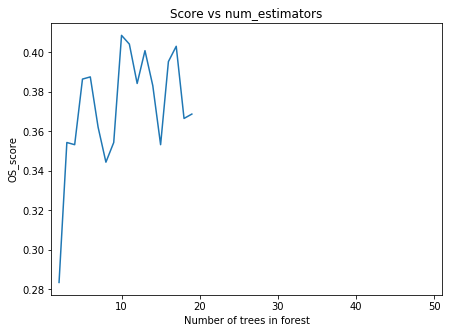

In [147]:

score=[]
for i in range(2,20,1):
    rf = RandomForestClassifier(n_estimators=1, max_leaf_nodes=i)
    rf.fit(X_train, y_train)
    pred=rf.predict_proba(X_test)
#     print(X_test.shape)
#     print(pred.shape,y_test.shape)
    score.append(rf.score(X_test,y_test))
print(score)

plt.figure(figsize=(7,5))
plt.plot(range(2,20,1),score)
plt.xlabel("Number of trees in forest")
plt.ylabel("OS_score")
plt.title("Score vs num_estimators")
plt.xlim(1,51)
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
[0.4019933554817276, 0.4019933554817276, 0.42524916943521596, 0.38870431893687707, 0.40310077519379844, 0.40863787375415284, 0.4097452934662237, 0.4097452934662237, 0.416389811738649, 0.4108527131782946, 0.42524916943521596, 0.4174972314507198, 0.4152823920265781, 0.4108527131782946, 0.4186046511627907, 0.4064230343300111, 0.4152823920265781, 0.4119601328903654, 0.41971207087486156]


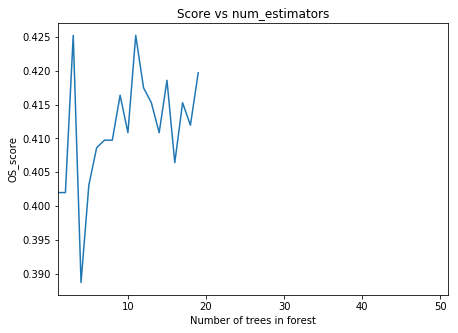

In [148]:

score=[]
for i in range(1,20,1):
    print(i)
    rf = RandomForestClassifier(n_estimators=i, max_leaf_nodes=10)
    rf.fit(X_train, y_train)
    pred=rf.predict_proba(X_test)
#     print(X_test.shape)
#     print(pred.shape,y_test.shape)
    score.append(rf.score(X_test,y_test))
print(score)

plt.figure(figsize=(7,5))
plt.plot(range(1,20,1),score)
plt.xlabel("Number of trees in forest")
plt.ylabel("OS_score")
plt.title("Score vs num_estimators")
plt.xlim(1,51)
plt.show()

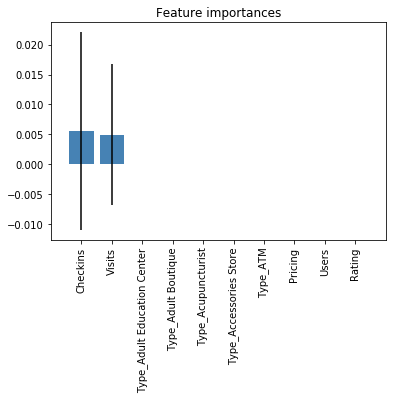

In [149]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_[:10]
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

    pl.figure()
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.show()
featureImportancePlot(rf, X_foursquare.columns)


# SVM

In [139]:
from sklearn.model_selection import GridSearchCV

# When C is very small, we are willing to tolerate more mistakes. If C is very big, this
# means we hardly tolerate any mistakes. So, we cannot choose a very large C if our data is not
# really separable. Let's however choose from a broad range of reasonable options.
# param_grid = {'kernel':['linear'],'C':[np.exp(i) for i in np.linspace(-10,10,10)]}
OS = []
for c in range(5):
    rr = svm.SVC()
#     gr=GridSearchCV(rr,param_grid=param_grid)
    rr.fit(X_train, y_train)
#     print(rr.best_estimator_)
    correct=1.0*(rr.predict(X_test)==np.asarray(y_test)).sum()/len(y_test)
    
    OS.append(correct)
model['SVM'] = mean(OS)

In [145]:
for i in modelslist:
    print(i)
for i in modelslist:
    print(model[i])
model.keys(), model.values()

Logit
DT
RF
SVM
0.3023255813953488
0.4407530454042082
0.40310077519379844
0.28017718715393136


(['Logit', 'DT', 'SVM', 'RF'],
 [0.3023255813953488,
  0.4407530454042082,
  0.28017718715393136,
  0.40310077519379844])

# Output
- outputs a .csv of the results
- You can refer to https://github.com/mv1742/updny_2